本章将介绍使用深度学习模型处理文本（可以将其理解为单词序列或字符序列）、时间序列和一般的序列数据。用于处理序列的两种基本的深度学习算法分别是

循环神经网络（recurrent neural network）和一维卷积神经网络（1D  convnet），

后者是上一章介绍的二维卷积神经网络的一维版本。本章将讨论这两种方法。   

这些算法的应用包括：

1. 文档分类和时间序列分类，比如识别文章的主题或书的作者；  
2. 时间序列对比，比如估测两个文档或两支股票行情的相关程度；  
3. 序列到序列的学习，比如将英语翻译成法语；   
4. 情感分析，比如将推文或电影评论的情感划分为正面或负面；   
5. 时间序列预测，比如根据某地最近的天气数据来预测未来天气。   

本章的示例重点讨论两个小任务：   
一个是 IMDB数据集的情感分析，这个任务前面介绍过；   
另一个是温度预测。   

但这两个任务中所使用的技术可以应用于上面列出来的所有应用。

本章的这些深度学习模型都没有像人类一样真正地理解文本，而只是映射出书面语言的统计结构，但这足以解决许多简单的文本任务。深度学习用于自然语言处理是将模式识别应用于单词、句子和段落，这与计算机视觉是将模式识别应用于像素大致相同。   

其他所有神经网络一样，深度学习模型不会接收原始文本作为输入，它只能处理数值张量。文本向量化（vectorize）是指将文本转换为数值张量的过程。它有多种实现方法。  

1. 将文本分割为单词，并将每个单词转换为一个向量。  
2. 将文本分割为字符，并将每个字符转换为一个向量。  
3. 提取单词或字符的   n-gram，并将每个 n-gram转换为一个向量。n-gram是多个连续单词或字符的集合（n-gram之间可重叠）

将文本分解而成的单元（单词、字符或   n-gram）叫作标记（token），将文本分解成标记的过程叫作分词（tokenization）。所有文本向量化过程都是应用某种分词方案，然后将数值向量与生成的标记相关联。这些向量组合成序列张量，被输入到深度神经网络中（见图   6-1）。将向量与标记相关联的方法有很多种。本节将介绍两种主要方法：对标记做   one-hot编码（one-hot encoding）与标记嵌入［token  embedding，通常只用于单词，叫作词嵌入（word   embedding）］。本节剩余内容将解释这些方法，并介绍如何使用这些方法，将原始文本转换为可以输入到  Keras网络中的 Numpy张量。

理解 n-gram和词袋

n-gram是从一个句子中提取的  N个（或更少）连续单词的集合。这一概念中的“单词”也可以替换为“字符”。

下面来看一个简单的例子。考虑句子“ The cat  sat on the  mat.”（“猫坐在垫子上”）。它可以被分解为以下二元语法（2-grams）的集合(最多一次取两个)。   

{"The", "The cat", "cat", "cat sat", "sat",
  "sat on", "on", "on the", "the", "the mat", "mat"}    
  
3-grams   
{"The", "The cat", "cat", "cat sat", "The cat sat",
  "sat", "sat on", "on", "cat sat on", "on the", "the",
  "sat on the", "the mat", "mat", "on the mat"}

这样的集合分别叫作二元语法袋（bag-of-2-grams）及三元语法袋（bag-of-3-grams）。这里袋（bag）这一术语指的是，我们处理的是标记组成的集合，而不是一个列表或序列，即标记没有特定的顺序。这一系列分词方法叫作词袋（bag-of-words）。

词袋是一种不保存顺序的分词方法（生成的标记组成一个集合，而不是一个序列，舍弃了句子的总体结构），因此它往往被用于浅层的语言处理模型，而不是深度学习模型。   

提取 n-gram是一种特征工程，深度学习不需要这种死板而又不稳定的方法，并将其替换为分层特征学习。本章后面将介绍的一维卷积神经网络和循环神经网络，都能够通过观察连续的单词序列或字符序列来学习单词组和字符组的数据表示，而无须明确知道这些组的存在。因此，本书不会进一步讨论 n-gram。   

但一定要记住，在使用轻量级的浅层文本处理模型时（比如 logistic回归和随机森林），n-gram是一种功能强大、不可或缺的特征工程工具

### 6.1.1　单词和字符的 one-hot编码

one-hot编码是将标记转换为向量的最常用、最基本的方法。在第  3章的  IMDB和路透社两个例子中，你已经用过这种方法（都是处理单词）。它将每个单词与一个唯一的整数索引相关联，然后将这个整数索引 i转换为长度为  N的二进制向量（N是词表大小），这个向量只有第   i个元素是 1，其余元素都为 0。

当然，也可以进行字符级的 one-hot编码。为了让你完全理解什么是   one-hot编码以及如何实现 one-hot编码，代码清单  6-1和代码清单 6-2给出了两个简单示例，一个是单词级的   one-hot编码，另一个是字符级的 one-hot编码。

In [40]:
import os, shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

In [41]:
# 单词级别 one-hot
samples =['The cat sat on the mat.','The dog ate my homework.']

token_index= {} # 构建数据中所有标记的索引

for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index)+1 # 为每个唯一单词指定一个唯一索引。没有为索引编号0指定单词

max_length=10
results= np.zeros(shape=(len(samples), #2
                        max_length, #10
                        max(token_index.values())+1)) #11

for i, sample in enumerate(samples): # [('0','The'),('1','cat')]
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index= token_index.get(word)
        results[i, j, index]=1. # 构建向量

In [42]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
list(enumerate(seasons))


[(0, 'Spring'), (1, 'Summer'), (2, 'Fall'), (3, 'Winter')]

In [7]:
results

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0

In [43]:
# 字符级别 one-hot

import string
samples =['The cat sat on the mat.','The dog ate my homework.']
characters = string.printable # 所有可以打印的 ASCII字符
token_index= dict(zip(range(1, len(characters)+1),characters)) # 构建数据中所有标记的索引

max_length=50
results= np.zeros((len(samples), max_length, max(token_index.keys())+1))

for i, sample in enumerate(samples): # [('0','The'),('1','cat')]
    for j, character in enumerate(sample):
        index= token_index.get(character)
        results[i, j, index]=1. # 构建向量


注意，Keras的内置函数可以对原始文本数据进行单词级或字符级的    one-hot编码。你应该使用这些函数，因为它们实现了许多重要的特性，比如从字符串中去除特殊字符、只考虑数据集中前 N个最常见的单词（这是一种常用的限制，以避免处理非常大的输入向量空间）。

In [44]:
#　用 Keras实现单词级的 one-hot编码

from tensorflow.keras.preprocessing.text import Tokenizer

samples =['The cat sat on the mat.','The dog ate my homework.']

tokenizer = Tokenizer(num_words= 1000) # 只考虑前10000个最常见的单词
tokenizer.fit_on_texts(samples) #构建单词索引

sequences= tokenizer.texts_to_sequences(samples)

one_hot_results= tokenizer.texts_to_matrix(samples, mode='binary') # 直接转换成二进制

word_index= tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 9 unique tokens.


one-hot编码的一种变体是所谓的  one-hot散列技巧（one-hot   hashing trick），如果词表中唯一标记的数量太大而无法直接处理，就可以使用这种技巧。这种方法没有为每个单词显式分配一个索引并将这些索引保存在一个字典中，而是将单词散列编码为固定长度的向量，通常用一个非常简单的散列函数来实现。这种方法的主要优点在于，它避免了维护一个显式的单词索引，从而节省内存并允许数据的在线编码（在读取完所有数据之前，你就可以立刻生成标记向量）。这种方法有一个缺点，就是可能会出现散列冲突（hash   collision），即两个不同的单词可能具有相同的散列值，随后任何机器学习模型观察这些散列值，都无法区分它们所对应的单词。如果散列空间的维度远大于需要散列的唯一标记的个数，散列冲突的可能性会减小。

In [45]:
# 使用散列技巧的单词级的 one-hot编码
samples =['The cat sat on the mat.','The dog ate my homework.']
dimensionality= 1000
max_length= 10

results = np.zeros((len(samples), max_length, dimensionality))

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index= abs(hash(word)) % dimensionality
        results[i,j, index]=1


### 6.1.2 使用词嵌入
将单词与向量相关联还有另一种常用的强大方法，就是使用密集的词向量（word    vector），也叫词嵌入（word embedding）。one-hot编码得到的向量是二进制的、稀疏的（绝大部分元素都是 0）、维度很高的（维度大小等于词表中的单词个数），而词嵌入是低维的浮点数向量（即密集向量，与稀疏向量相对），参见图 6-2。与 one-hot编码得到的词向量不同，词嵌入是从数据中学习得到的。常见的词向量维度是  256、512或  1024（处理非常大的词表时）。与此相对，one-hot编码的词向量维度通常为  20 000或更高（对应包含  20 000个标记的词表）。因此，词向量可以将更多的信息塞入更低的维度中.    

获取词嵌入有两种方法。

在完成主任务（比如文档分类或情感预测）的同时学习词嵌入。在这种情况下，一开始是随机的词向量，然后对这些词向量进行学习，其学习方式与学习神经网络的权重相同。    

在不同于待解决问题的机器学习任务上预计算好词嵌入，然后将其加载到模型中。这些词嵌入叫作预训练词嵌入（pretrained word embedding）

#### 1.利用Embedding层学习词嵌入  

将一个Embedding层实例化时，它的权重（即标记向量的内部字典）最开始是随机的，与其他层一样。在训练过程中，利用反向传播来逐渐调节这些词向量，改变空间结构以便下游模型可以利用。一旦训练完成，嵌入空间将会展示大量结构，这种结构专门针对训练模型所要解决的问题。

我们将这个想法应用于你熟悉的  IMDB电影评论情感预测任务。首先，我们需要快速准备数据。将电影评论限制为前 10  000个最常见的单词（第一次处理这个数据集时就是这么做的），然后将评论长度限制为只有  20个单词。对于这   10  000个单词，网络将对每个词都学习一个8维嵌入，将输入的整数序列（二维整数张量）转换为嵌入序列（三维浮点数张量），然后将这个张量展平为二维，最后在上面训练一个Dense层用于分类。


In [46]:
from tensorflow.keras.layers import Embedding

embedding_layer= Embedding(1000,64) # Embedding 层至少需要两个参数： 标记的个数 (这里是1000，即最大的单词索引+1)和嵌入维度64


In [47]:
# 加载 IMDB数据，准备用于Embedding层
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing
max_features= 10000
maxlen=20
(x_train, y_train), (x_test, y_test)= imdb.load_data(num_words= max_features)

x_train=preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test=preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)


In [64]:
# 在 IMDB数据上使用Embedding层和分类器
model = Sequential()
model.add(Embedding(10000, 8, input_length= maxlen)) # 指定最大输入长度，方便后面将嵌入输入展平。

model.add(Flatten()) # 将 三维的嵌入张量 展平成形状为 (samples, maxlen * 8)的二维张量

model.add(Dense(1, activation='sigmoid')) # 分类器

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics= ['acc'])

model.summary()
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 20, 8)             80000     
_________________________________________________________________
flatten_18 (Flatten)         (None, 160)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 1s 817us/step - loss: 0.6887 - acc: 0.5478 - val_loss: 0.6404 - val_acc: 0.6854
Epoch 2/10
625/625 [==============================] - 0s 720us/step - loss: 0.5867 - acc: 0.7491 - val_loss: 0.5357 - val_acc: 0.7264
Epoch 3/10
625/625 [==============================] - 0s 687us/step - loss: 0.4749 - acc: 0.7844 - val_loss: 0.

得到的验证精度约为 76%，考虑到仅查看每条评论的前 20个单词，这个结果还是相当不错的。但请注意，仅仅将嵌入序列展开并在上面训练一个 Dense层，会导致模型对输入序列中的每个单词单独处理，而没有考虑单词之间的关系和句子结构（举个例子，这个模型可能会将  this movie is a bomb和  this movie is the bomb两条都归为负面评论）。更好的做法是在嵌入序列上添加循环层或一维卷积层，将每个序列作为整体来学习特征。这也是接下来几节的重点

#### 2.使用预训练的词嵌入
你可以从预计算的嵌入空间中加载嵌入向量（你知道这个嵌入空间是高度结构化的，并且具有有用的属性，即抓住了语言结构的一般特点），而不是在解决问题的同时学习词嵌入。在自然语言处理中使用预训练的词嵌入，其背后的原理与在图像分类中使用预训练的卷积神经网络是一样的：没有足够的数据来自己学习真正强大的特征，但你需要的特征应该是非常通用的，比如常见的视觉特征或语义特征。在这种情况下，重复使用在其他问题上学到的特征，这种做法是有道理的

### 6.1.3　整合在一起：从原始文本到词嵌入

In [65]:
#1.下载  IMDB数据的原始文本
# http://ai.stanford.edu/~amaas/data/sentiment/
import os

imdb_dir = '/Users/yihuawang/Deeplearning/aclImdb/'
train_dir = os.path.join(imdb_dir, 'train') # 进入 train 文件夹

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type) # 进入 negative/positive 文件夹
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt': # 读取txt文件
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg': # 对文件进行标记
                labels.append(0)
            else:
                labels.append(1)

In [73]:
len(texts)

25000

In [77]:
# 2.对数据进行分词
# Tokenize the data

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words 在一百个单词后截断评论
training_samples = 200  # We will be training on 200 samples 在两百个样本上训练
validation_samples = 10000  # We will be validating on 10000 samples 在10000个样本上验证
max_words = 10000  # We will only consider the top 10,000 words in the dataset 只考虑数居前10000个字

tokenizer = Tokenizer(num_words=max_words) #创造一个分词器，只考虑前10000个最常见的单词
tokenizer.fit_on_texts(texts) #构建单词索引
sequences = tokenizer.texts_to_sequences(texts) # 将字符串转换成整数索引组成的列表

word_index = tokenizer.word_index # 找回单词索引
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen) # 将列表中的序列的长度插补成100

labels = np.asarray(labels) #Convert the input to an array.
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data ## 洗牌
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [78]:
# 3.下载  GloVe词嵌入
# wget https://nlp.stanford.edu/data/glove.6B.zip
# 4.对嵌入进行预处理
glove_dir = '/Users/yihuawang/Deeplearning/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


接下来，需要构建一个可以加载到Embedding层中的嵌入矩阵。它必须是一个形状为(max_words, embedding_dim)的矩阵，对于单词索引（在分词时构建）中索引为   i的单词，这个矩阵的元素 i就是这个单词对应的embedding_dim维向量。注意，索引    0不应该代表任何单词或标记，它只是一个占位符。

In [83]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros. 找不到的词，嵌入索引都为0
            embedding_matrix[i] = embedding_vector

In [84]:
# 5.定义模型
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_19 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [85]:
# 6.在模型中加载  GloVe嵌入
# Embedding层只有一个权重矩阵，是一个二维的浮点数矩阵，其中每个元素i是与索引i相关联的词向量。够简单。
# 将准备好的 GloVe矩阵加载到Embedding层中，即模型的第一层。
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [90]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.071953  ,  0.23127   ,  0.023731  , ..., -0.71894997,
         0.86894   ,  0.19539   ],
       ...,
       [-0.44036001,  0.31821999,  0.10778   , ..., -1.29849994,
         0.11824   ,  0.64845002],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.54539001, -0.31817999, -0.016281  , ..., -0.44865   ,
         0.067047  ,  0.17975999]])

此外，需要冻结Embedding层（即将其trainable属性设为False），其原理和预训练的卷积神经网络特征相同，你已经很熟悉了。如果一个模型的一部分是经过预训练的（如Embedding层），而另一部分是随机初始化的（如分类器），那么在训练期间不应该更新预训练的部分，以避免丢失它们所保存的信息。随机初始化的层会引起较大的梯度更新，会破坏已经学到的特征。

In [87]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_19 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [88]:
# 7.训练模型与评估模型

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 59ms/step - loss: 1.8199 - acc: 0.4468 - val_loss: 0.7364 - val_acc: 0.5054
Epoch 2/10
7/7 [==============================] - 0s 38ms/step - loss: 0.5388 - acc: 0.6916 - val_loss: 2.3670 - val_acc: 0.5020
Epoch 3/10
7/7 [==============================] - 0s 39ms/step - loss: 0.8371 - acc: 0.8133 - val_loss: 0.7836 - val_acc: 0.5122
Epoch 4/10
7/7 [==============================] - 0s 38ms/step - loss: 0.2734 - acc: 0.9515 - val_loss: 0.8453 - val_acc: 0.5062
Epoch 5/10
7/7 [==============================] - 0s 37ms/step - loss: 0.3548 - acc: 0.7906 - val_loss: 0.7885 - val_acc: 0.5239
Epoch 6/10
7/7 [==============================] - 0s 37ms/step - loss: 0.1504 - acc: 1.0000 - val_loss: 1.1840 - val_acc: 0.5033
Epoch 7/10
7/7 [==============================] - 0s 37ms/step - loss: 0.2252 - acc: 0.8944 - val_loss: 0.7689 - val_acc: 0.5475
Epoch 8/10
7/7 [==============================] - 0s 37ms/step - loss: 0.0741 - acc: 1.0000 - val

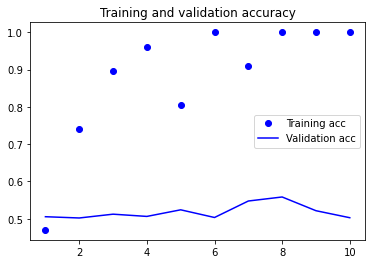

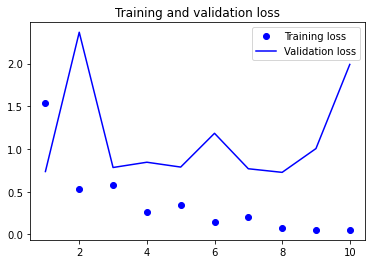

In [89]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

模型很快就开始过拟合，考虑到训练样本很少，这一点也不奇怪。出于同样的原因，验证精度的波动很大，但似乎达到了接近 60%。

注意，你的结果可能会有所不同。训练样本数太少，所以模型性能严重依赖于你选择的200个样本，而样本是随机选择的。如果你得到的结果很差，可以尝试重新选择    200个不同的随机样本，你可以将其作为练习（在现实生活中无法选择自己的训练数据）。

你也可以在不加载预训练词嵌入、也不冻结嵌入层的情况下训练相同的模型。在这种情况下，你将会学到针对任务的输入标记的嵌入。如果有大量的可用数据，这种方法通常比预训练词嵌入更加强大，但本例只有 200个训练样本。我们来试一下这种方法（见图 6-7和图  6-8）

In [91]:
# 在不使用预训练词嵌入的情况下，训练相同的模型

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_20 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 1s 71ms/step - loss: 0.6887 - acc: 0.5992 - val_loss: 0.6921 - val_acc: 0.5115
Epoch 2/10
7/7 [==============================] - 0s 42ms/step - loss: 0.4781 - acc: 0.9950 - val_loss: 0.6967 -

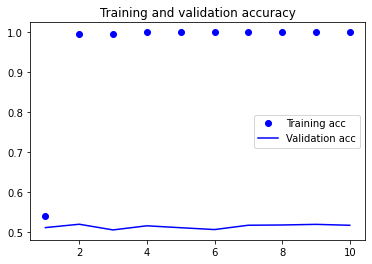

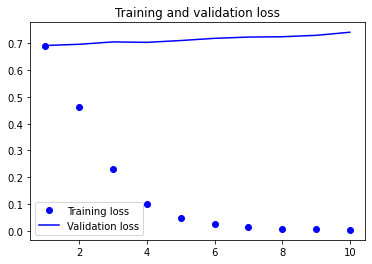

In [92]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
# 很快过拟合

In [93]:
# 对测试集数据进行分词

test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [94]:
# 在测试集上评估模型
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 690us/step - loss: 1.9885 - acc: 0.5003


[1.9884874820709229, 0.5002800226211548]

### 小结
现在你已经学会了下列内容。

1. 将原始文本转换为神经网络能够处理的格式。   
2. 使用  Keras模型的Embedding层来学习针对特定任务的标记嵌入。  
3. 使用预训练词嵌入在小型自然语言处理问题上获得额外的性能提升。